# cuDSMC simple example

## Define potential with the freedom to use either numpy or sympy for calculations

In [1]:
#e.g. crossed dipole trap for cold atoms evaporation
def crossedDipole(compute):
    def potential(x,y,z,t):
        P=2
        w0_h=200e-6
        w0_v=50e-6
        A=-2e-36 
        def w(z,w0):
            zR=np.pi*w0**2/1064e-9
            return w0*compute.sqrt(1+(z/zR)**2)
        def I1(x,z,t,w0):
            return compute.sqrt(2*P/np.pi)/w(z,w0)*compute.exp(-2*x**2/w(z,w0)**2)
        def U(x,y,z,t):
            x_new=(x+z)/np.sqrt(2)
            z_new=(x-z)/np.sqrt(2)
            return A*(I1(x_new,z_new,t,w0_h)*I1(y,z_new,t,w0_v)+I1(z_new,x_new,t,w0_h)*I1(y,x_new,t,w0_v))
        return U(x,y,z,t)
    return potential

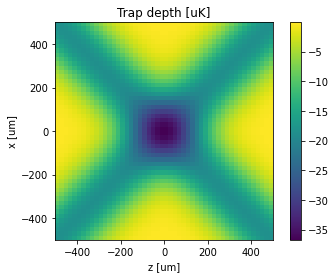

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
x,z=np.meshgrid(np.linspace(-500e-6,500e-6),np.linspace(-500e-6,500e-6),indexing="ij")
plt.imshow(crossedDipole(np)(x,0,z,0)/1.38e-23/1e-6,extent=[z[0,0]*1e6,z[0,-1]*1e6,x[0,0]*1e6,x[-1,0]*1e6])
plt.xlabel("z [um]")
plt.ylabel("x [um]")
plt.title("Trap depth [uK]")
plt.colorbar();

## Define intial thermal distribution

In [3]:
from scipy.misc import derivative

kT=1.38e-23*20e-6
Rb_87={"mass":1.4e-25}

U=crossedDipole(np)
wx=(derivative(lambda x:U(x,0,0,0),0,1e-6,n=2)/Rb_87["mass"]*2)**.5
wy=(derivative(lambda y:U(0,y,0,0),0,1e-6,n=2)/Rb_87["mass"]*2)**.5
wz=(derivative(lambda z:U(0,0,z,0),0,1e-6,n=2)/Rb_87["mass"]*2)**.5

sx=np.sqrt(kT/Rb_87["mass"]/wx**2)
sy=np.sqrt(kT/Rb_87["mass"]/wy**2)
sz=np.sqrt(kT/Rb_87["mass"]/wz**2)
sv=np.sqrt(kT/Rb_87["mass"])

NT=100000#number simulation particles
r0=np.array([np.random.normal(loc=0,scale=sx,size=NT),np.random.normal(loc=0,scale=sy,size=NT),np.random.normal(loc=0,scale=sz,size=NT)])
v0=np.array([np.random.normal(size=NT,scale=sv),np.random.normal(size=NT,scale=sv) ,np.random.normal(size=NT,scale=sv)])

## Initialise DSMC simulation:

In [4]:
from DSMC import DSMC
import sympy as sym
a=DSMC(r0,v0)
parameters=dict(Rb_87)
parameters["number"]=5e6
parameters["cross-section"]=8*np.pi*(5.7e-9)**2
a.setPotential(crossedDipole(sym),parameters,NewtonIter=0)

## Evolve the situation to a given time:

In [5]:
a.cuDSMC.update(a.cuDSMC.getTime()+10e-3);

## Plot potential and particles distribution

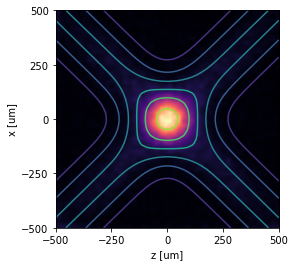

In [6]:
fig=plt.figure(figsize=(4,4))
xmin=-500e-6
xmax=500e-6
zmin=-500e-6
zmax=500e-6
NX=50
NZ=50

X,Z=np.meshgrid(np.linspace(xmin,xmax),np.linspace(zmin,zmax))

h=a.histogram(min_x=xmin,max_x=xmax,NX=NX,min_z=zmin,max_z=zmax,NZ=NZ)
im=plt.imshow(h,origin="lower",extent=[zmin*1e6,zmax*1e6,xmin*1e6,xmax*1e6],aspect="auto",interpolation="bilinear",cmap="magma")

plt.contour(X*1e6,Z*1e6,-U(X,0,Z,0))
plt.ylabel("x [um]")
plt.xlabel("z [um]")
plt.xlim(zmin*1e6,zmax*1e6)
plt.ylim(xmin*1e6,xmax*1e6)
plt.xticks([-500,-250,0,250,500])
plt.yticks([-500,-250,0,250,500]);

## Inspect AMR grid

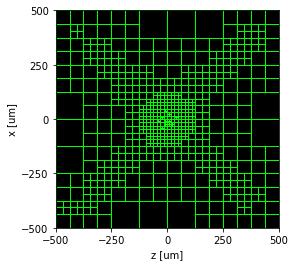

In [7]:
fig=plt.figure(figsize=(4,4))
plt.tight_layout()
ax=plt.subplot()
ax.set_facecolor("black")

plt.ylabel("x [um]")
plt.xlabel("z [um]")
plt.xlim(zmin*1e6,zmax*1e6)
plt.ylim(xmin*1e6,xmax*1e6)
plt.xticks([-500,-250,0,250,500])
plt.yticks([-500,-250,0,250,500])
for (n,l,(xmin,ymin,zmin),(xmax,ymax,zmax),imin,imax,index,vrMax) in a.cuDSMC.getGrid():
    plt.plot(np.array([zmin,zmax,zmax,zmin,zmin])*1e6,np.array([xmin,xmin,xmax,xmax,xmin])*1e6,color="lime",lw=1)

